In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os

In [4]:
flname = '/home/tristan/mesmer/data/obs_data_25.nc'

ds = xr.open_dataset(flname)

In [3]:
ds.info()

xarray.Dataset {
dimensions:
	longitude = 360 ;
	latitude = 180 ;
	time = 2064 ;
	month_number = 12 ;

variables:
	float32 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:standard_name = longitude ;
		longitude:long_name = Longitude ;
	float32 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = Latitude ;
	float64 time(time) ;
		time:units = year A.D. ;
		time:standard_name = time ;
		time:long_name = Time ;
	float64 land_mask(latitude, longitude) ;
		land_mask:units = none ;
		land_mask:standard_name = land_mask ;
		land_mask:long_name = Land Mask ;
		land_mask:valid_min = 0.0 ;
		land_mask:valid_max = 1.0 ;
	float32 temperature(time, latitude, longitude) ;
		temperature:units = degree C ;
		temperature:standard_name = surface_temperature_anomaly ;
		temperature:long_name = Air Surface Temperature Anomaly ;
		temperature:valid_min = -16.075339977697816 ;
		temperature:valid_max = 17.68661490173582 ;

# Change time to datetime64

In [7]:
dates = pd.date_range(start=f'1850-01T00:00:00.000000000', 
                      end=f'2021-12T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
ds['time'] = dates

# Cos weighting

In [18]:
def cos_wgt(ds):
    
    from numpy import cos, deg2rad
    
    weights = np.cos(np.deg2rad(ds.lat))
    
    return weights

In [19]:
weights = cos_wgt(ds)

In [21]:
print(weights)

<xarray.DataArray 'lat' (lat: 72)>
array([0.02181489, 0.06540313, 0.10886687, 0.15212339, 0.19509032,
       0.23768589, 0.27982901, 0.32143947, 0.36243804, 0.40274669,
       0.44228869, 0.48098877, 0.51877326, 0.55557023, 0.59130965,
       0.62592347, 0.65934582, 0.69151306, 0.72236396, 0.75183981,
       0.77988448, 0.8064446 , 0.83146961, 0.85491187, 0.87672676,
       0.89687274, 0.91531148, 0.93200787, 0.94693013, 0.96004985,
       0.97134207, 0.98078528, 0.98836151, 0.99405634, 0.99785892,
       0.99976203, 0.99976203, 0.99785892, 0.99405634, 0.98836151,
       0.98078528, 0.97134207, 0.96004985, 0.94693013, 0.93200787,
       0.91531148, 0.89687274, 0.87672676, 0.85491187, 0.83146961,
       0.8064446 , 0.77988448, 0.75183981, 0.72236396, 0.69151306,
       0.65934582, 0.62592347, 0.59130965, 0.55557023, 0.51877326,
       0.48098877, 0.44228869, 0.40274669, 0.36243804, 0.32143947,
       0.27982901, 0.23768589, 0.19509032, 0.15212339, 0.10886687,
       0.06540313, 0.021814

In [32]:
ds_weighted = ds.weighted(weights)
ds_weighted

DatasetWeighted with weights along dimensions: lat

In [58]:
weighted_mean = ds_weighted.mean(("lat", "lon"))
weighted_mean 

<xarray.Dataset>
Dimensions:      (time: 2064, month_number: 12)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-15 1850-02-15 ... 2021-12-15
Dimensions without coordinates: month_number
Data variables:
    land_mask    float64 0.2884
    temperature  (time) float64 -0.666 -0.1851 -0.3392 ... 0.8987 0.8648 0.7569
    climatology  (month_number) float64 12.93 13.2 13.79 ... 14.8 13.79 13.15

In [36]:
weighted_mean_smooth = weighted_mean.rolling(time=12*5, center=True).mean().dropna("time")

In [37]:
ds_mean = ds['temperature'].mean(("lat", "lon"))
standard_mean_smooth = ds_mean.rolling(time=12*5, center=True).mean().dropna("time")

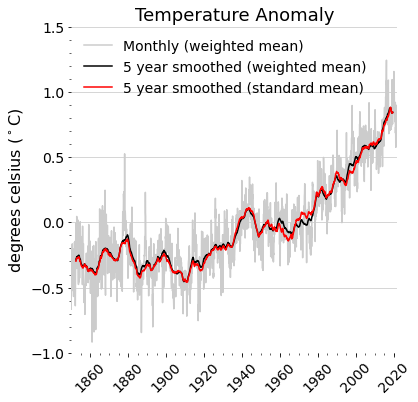

In [41]:
### change the date time

dates = pd.date_range(start=f'1850-01T00:00:00.000000000', 
                      end=f'2021-12T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
ds_mean['time'] = dates
weighted_mean['time']=dates


# --------------------------------------------
# setup the figure
# --------------------------------------------
fig = plt.figure(figsize=(6,6)) 
ax = fig.add_subplot(111)

# --------------------------------------------
# plot the data
# --------------------------------------------
#ax.plot(ds['time'], standard_mean, color=[1,0.8,0.8], label='Monthly (weighted mean)')
ax.plot(ds['time'], weighted_mean, color=[0.8,0.8,0.8], label='Monthly (weighted mean)')
ax.plot(weighted_mean_smooth['time'], weighted_mean_smooth, color='k', label='5 year smoothed (weighted mean)')
ax.plot(standard_mean_smooth['time'], standard_mean_smooth, color='r', label='5 year smoothed (standard mean)')

# --------------------------------------------
# plot legend
# --------------------------------------------
ax.legend(loc='upper left',frameon=False, fontsize=14)

# --------------------------------------------
# Range of axes
# --------------------------------------------
ax.set_ylim([-1, 1.5])
ax.set_xlim([np.datetime64('1850-01-15'), np.datetime64('2021-12-15')])

# --------------------------------------------
# Labels
# --------------------------------------------
ax.set_ylabel(f'degrees celsius ($^\circ$C)', fontsize=16)
ax.set_title(f'Temperature Anomaly', fontsize=18)

# --------------------------------------------
# Fontsize and rotation of axis labels
# --------------------------------------------
ax.tick_params(axis='x', rotation=45, labelsize=14)
ax.tick_params(axis='y', rotation=0, labelsize=14)

# --------------------------------------------
# Turn off the display of all ticks.
# --------------------------------------------
ax.tick_params(which='both',   # Options for both major and minor ticks
                top='off',     # turn off top ticks
                left='off',    # turn off left ticks
                right='off',   # turn off right ticks
                bottom='off',) # turn off bottom ticks


# --------------------------------------------
# Hide the right and top spines
# --------------------------------------------
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# --------------------------------------------
# major / minor tick spaces
# --------------------------------------------
ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator(5)) 
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(axis='y', which='major', color=[0.8,0.8,0.8], linestyle='-')

# --------------------------------------------
# Only show ticks on the left and bottom spines
# --------------------------------------------
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# --------------------------------------------
# Make axis square
# --------------------------------------------
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

# --------------------------------------------
# Don't allow the axis to be on top of your data
# --------------------------------------------
ax.set_axisbelow(True)

# --------------------------------------------
# save figure
# --------------------------------------------
plt.savefig(f'./flux_time-series.pdf', 
                transparent = True, 
                bbox_inches = 'tight', 
                pad_inches = 0)